[Titanic: Machine Learning from Disaster | Kaggle](https://www.kaggle.com/c/titanic/data)

In [244]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [245]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [246]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import re
sns.set_style('whitegrid')
sns.set_palette('Set1')

## 1 导入数据

In [247]:
datadir = 'dataset/'

In [248]:
# read data from file
train_data = pd.read_csv(f'{datadir}train.csv')
test_data = pd.read_csv(f'{datadir}test.csv')

## 2 数据基本信息

In [249]:
train_data.head()
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [250]:
train_data.describe()
test_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [251]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [252]:
# 备份数据
# 因为要做一些统一处理，所以将训练集测试集拼接起来
train = train_data
test = test_data
all_data = pd.concat([train, test], axis=0, sort=False)

In [253]:
train.shape, test.shape, all_data.shape

((891, 12), (418, 11), (1309, 12))

In [254]:
# one-hot编码
def dummies(col,data):
    data_dum = pd.get_dummies(data[col])
    data = pd.concat([data, data_dum], axis=1)
    data.drop(col, axis=1, inplace=True)
    return data

## 3 分类变量分析

In [255]:
# 获取所有的列名
all_data.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

数据总共有12个变量，其中PassengerId、Survived两个变量分别是样本编号和预测目标，这里暂时不考虑。由于test数据集在应用最终模型的过程之前都是未知的，所以，这里主要分析train，之后将相同的预处理操作应用到test，以保证模型的泛化能力。

### 3.1 Pclass

In [256]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Pclass一共有三种数值，其中Pclass3的人数最多

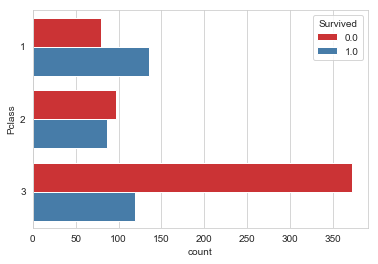

In [257]:
sns.countplot(y='Pclass', hue='Survived', data=all_data)

上图可以看出：Pclass=1的乘客中，存活的数量明显大于死亡的人数，而Pclass=2的乘客生存和死亡的数量大致是相当的，Pclass=3的乘客死亡的人数占多数；这充分说明Pclass对最终的预测有很大的影响，是一个重要的特征。

In [258]:
any(all_data.Pclass.isna())

False

In [259]:
all_data.Pclass.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [260]:
all_data = dummies('Pclass', all_data)

In [261]:
all_data.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,1,2,3
0,1,0.0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1.0,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0.0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1


In [262]:
all_data.rename(columns={1: 'Pclass1', 2: 'Pclass2', 3: 'Pclass3'}, inplace=True)

In [263]:
all_data.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass1,Pclass2,Pclass3
0,1,0.0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1.0,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0.0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1


In [264]:
backup1 = all_data
train = all_data[:891]
test = all_data[-418:]

### 3.2 Name

In [265]:
# 恢复数据
all_data = backup1

In [266]:
any(all_data.Name.isna())

False

In [267]:
all_data.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

名字中最有用的信息就是称呼，例如Mrs. 鸟事已经结婚的太太, Miss 表示未结婚的年轻女子，Master表示研究生等，社会地位的高低可能会影响最终的生存情况。首先，将称呼提取出来，然后观察是否与生存有关。

In [268]:
title = all_data.Name.map(lambda x: re.compile(",(.*?)\.").findall(x)[0].strip())

In [269]:
title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [270]:
# 将 title 添加到最后
all_data['Title'] = title
all_data.drop('Name', axis=1, inplace=True)

In [271]:
all_data.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass1,Pclass2,Pclass3,Title
0,1,0.0,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,Mr
1,2,1.0,female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,Mrs
2,3,1.0,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,Miss
3,4,1.0,female,35.0,1,0,113803,53.1000,C123,S,1,0,0,Mrs
4,5,0.0,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,Mr


In [272]:
backup2 = all_data
train = all_data[:891]
test = all_data[-418:]

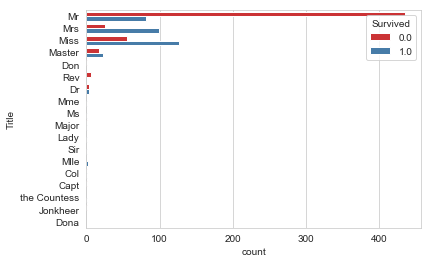

In [273]:
sns.countplot(y='Title', hue='Survived', data=all_data)

In [274]:
all_data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Sir               1
the Countess      1
Dona              1
Capt              1
Mme               1
Don               1
Jonkheer          1
Lady              1
Name: Title, dtype: int64

这里有法语有英语，我们统一为英语并且合并数量较少的类别:
* Mlle, Lady, Jonkheer, Dona --> Ms
* Mme --> Mrs
* Don, Sir, Rev, Col --> Mr
* Ms --> Miss
* Major, Master, Dr, the Countess, Capt --> High

In [275]:
all_data.Title.replace({'Mlle': 'Ms', 'Lady': 'Ms', 'Dona': 'Ms', 'Jonkheer': 'Ms', 'Mme': 'Mrs', 
                        'Don': 'Mr', 'Sir': 'Mr', 'Rev': 'Mr', 'Col': 'Mr', 'Major': 'High', 'Ms': 'Miss',
                        'Master': 'High', 'Dr': 'High', 'the Countess': 'High', 'Capt': 'High'}, inplace=True)

In [276]:
all_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'High'], dtype=object)

In [277]:
all_data.Title.value_counts()

Mr      771
Miss    267
Mrs     198
High     73
Name: Title, dtype: int64

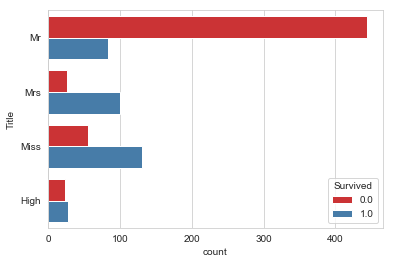

In [278]:
sns.countplot(y='Title', hue='Survived', data=all_data)

最终只留下四个类别，这些特征可能与性别存在冲突

In [279]:
all_data = dummies('Title', all_data)

In [280]:
backup2 = all_data

### 3.3 Sex

In [281]:
all_data = backup2

In [282]:
any(all_data.Sex.isna())

False

In [283]:
all_data.Sex.value_counts()

male      843
female    466
Name: Sex, dtype: int64

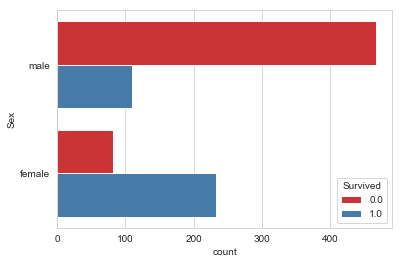

In [284]:
sns.countplot(y='Sex', hue='Survived', data=all_data)

In [285]:
all_data = dummies('Sex', all_data)

In [286]:
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male
0,1,0.0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,1,0,0,1
1,2,1.0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,0,0,0,1,1,0
2,3,1.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0,1,0,0,1,0
3,4,1.0,35.0,1,0,113803,53.1000,C123,S,1,0,0,0,0,0,1,1,0
4,5,0.0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,1,0,0,1


In [287]:
backup3 = all_data

### 3.4 Age

年龄因素必然是会对生存情况存在重要影响的，老人小孩一定会有更大的生存机会，而青年人相对较小的生存几率。

In [288]:
all_data = backup3

In [289]:
any(all_data.Age.isna()) # 存在空值

True

In [290]:
num_nona = all_data.Age.count() # 非空数值个数
num_nona

1046

In [291]:
num_na = all_data.Age.shape[0] - num_nona  # 空值个数
num_na

263

In [292]:
# 去掉空值行
nona_data = all_data.Age.dropna(axis=0, how='all', inplace=False)

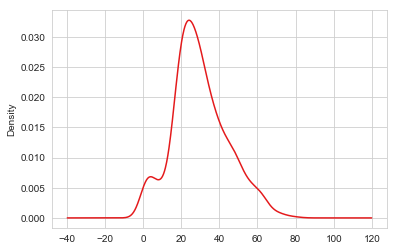

In [293]:
# 未缺失的年龄的大致分布
nona_data.plot(kind='kde')

In [294]:
nona_data.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

插值方式：
* Mr, Miss --> 21
* Mrs --> 28
* High --> 39

In [295]:
data = all_data.values
data.shape
len = data.shape[0]

(1309, 18)

In [296]:
for idx in range(len):
    tmp = data[idx, 2]
    if np.isnan(tmp):
        if data[idx, 12] == 1:
            data[idx, 2] = 39.
        elif data[idx, 13] == 1 or data[idx, 14] == 1:
            data[idx, 2] = 21.
        else:
            data[idx, 2] = 28.
    else:
        continue

In [297]:
all_data['Age'] = data[:, 2]

In [298]:
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male
0,1,0.0,22,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,1,0,0,1
1,2,1.0,38,1,0,PC 17599,71.2833,C85,C,1,0,0,0,0,0,1,1,0
2,3,1.0,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0,1,0,0,1,0
3,4,1.0,35,1,0,113803,53.1000,C123,S,1,0,0,0,0,0,1,1,0
4,5,0.0,35,0,0,373450,8.0500,NaN,S,0,0,1,0,0,1,0,0,1


In [299]:
all_data.shape

(1309, 18)

In [300]:
any(all_data.Age.isna())

False

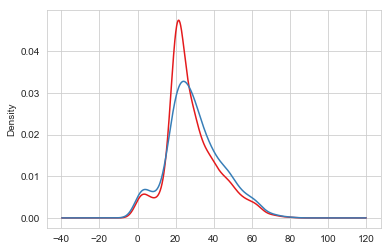

In [301]:
# 整体年龄的大致分布
all_data.Age.plot(kind='kde')
# 未缺失的年龄的大致分布
nona_data.plot(kind='kde')

### 3.5 Ticket

* Ticket 没有什么用处所以删除

In [302]:
all_data.drop(columns=['Ticket'], axis=1, inplace=True)

In [303]:
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male
0,1,0.0,22,1,0,7.2500,NaN,S,0,0,1,0,0,1,0,0,1
1,2,1.0,38,1,0,71.2833,C85,C,1,0,0,0,0,0,1,1,0
2,3,1.0,26,0,0,7.9250,NaN,S,0,0,1,0,1,0,0,1,0
3,4,1.0,35,1,0,53.1000,C123,S,1,0,0,0,0,0,1,1,0
4,5,0.0,35,0,0,8.0500,NaN,S,0,0,1,0,0,1,0,0,1


In [304]:
all_data.shape

(1309, 17)

### 3.6 Cabin

In [305]:
nona = all_data.Cabin.count()
nona

295

In [306]:
num_na =all_data.shape[0] - nona
num_na

1014

缺失值太多，所以选择删除该列

In [307]:
all_data.drop(columns=['Cabin'], axis=1, inplace=True)

In [308]:
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Embarked,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male
0,1,0.0,22,1,0,7.2500,S,0,0,1,0,0,1,0,0,1
1,2,1.0,38,1,0,71.2833,C,1,0,0,0,0,0,1,1,0
2,3,1.0,26,0,0,7.9250,S,0,0,1,0,1,0,0,1,0
3,4,1.0,35,1,0,53.1000,S,1,0,0,0,0,0,1,1,0
4,5,0.0,35,0,0,8.0500,S,0,0,1,0,0,1,0,0,1


In [309]:
all_data.shape

(1309, 16)

### 3.7 Embarked

In [310]:
any(all_data.Embarked.isna())

True

In [311]:
nona = all_data.Embarked.count()
nona

1307

In [312]:
num_na =all_data.shape[0] - nona
num_na

2

In [313]:
all_data.Embarked.describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

* 使用众数进行插值
* one-hot编码

In [314]:
all_data.Embarked.fillna('S', inplace=True)
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Embarked,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male
0,1,0.0,22,1,0,7.2500,S,0,0,1,0,0,1,0,0,1
1,2,1.0,38,1,0,71.2833,C,1,0,0,0,0,0,1,1,0
2,3,1.0,26,0,0,7.9250,S,0,0,1,0,1,0,0,1,0
3,4,1.0,35,1,0,53.1000,S,1,0,0,0,0,0,1,1,0
4,5,0.0,35,0,0,8.0500,S,0,0,1,0,0,1,0,0,1


In [315]:
any(all_data.Embarked.isna())

False

In [316]:
all_data = dummies('Embarked', all_data)

In [317]:
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male,C,Q,S
0,1,0.0,22,1,0,7.2500,0,0,1,0,0,1,0,0,1,0,0,1
1,2,1.0,38,1,0,71.2833,1,0,0,0,0,0,1,1,0,1,0,0
2,3,1.0,26,0,0,7.9250,0,0,1,0,1,0,0,1,0,0,0,1
3,4,1.0,35,1,0,53.1000,1,0,0,0,0,0,1,1,0,0,0,1
4,5,0.0,35,0,0,8.0500,0,0,1,0,0,1,0,0,1,0,0,1


### 3.8 SibSp and Parch

* SibSp: 有误兄弟姐妹和配偶在船上
* Parch： 有无父母在船上

In [318]:
any(all_data.SibSp.isna())
any(all_data.Parch.isna())

False

False

* 不存在空值
* 兄弟姐妹、配偶、父母都是家庭成员的一部分
* 如果船上有任意的家庭成员，那么其本人一定会优先考虑妻子老人或者小孩
* 使用二者的和作为新的特征

In [319]:
all_data['Family'] = all_data['SibSp'] + all_data['Parch']
all_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male,C,Q,S,Family
0,1,0.0,22,1,0,7.2500,0,0,1,0,0,1,0,0,1,0,0,1,1
1,2,1.0,38,1,0,71.2833,1,0,0,0,0,0,1,1,0,1,0,0,1
2,3,1.0,26,0,0,7.9250,0,0,1,0,1,0,0,1,0,0,0,1,0
3,4,1.0,35,1,0,53.1000,1,0,0,0,0,0,1,1,0,0,0,1,1
4,5,0.0,35,0,0,8.0500,0,0,1,0,0,1,0,0,1,0,0,1,0


In [320]:
all_data.drop(columns=['SibSp', 'Parch'], axis=1, inplace=True)

In [321]:
all_data.head(10)

,PassengerId,Survived,Age,Fare,Pclass1,Pclass2,Pclass3,High,Miss,Mr,Mrs,female,male,C,Q,S,Family
0,1,0.0,22,7.2500,0,0,1,0,0,1,0,0,1,0,0,1,1
1,2,1.0,38,71.2833,1,0,0,0,0,0,1,1,0,1,0,0,1
2,3,1.0,26,7.9250,0,0,1,0,1,0,0,1,0,0,0,1,0
3,4,1.0,35,53.1000,1,0,0,0,0,0,1,1,0,0,0,1,1
4,5,0.0,35,8.0500,0,0,1,0,0,1,0,0,1,0,0,1,0
5,6,0.0,21,8.4583,0,0,1,0,0,1,0,0,1,0,1,0,0
6,7,0.0,54,51.8625,1,0,0,0,0,1,0,0,1,0,0,1,0
7,8,0.0,2,21.0750,0,0,1,1,0,0,0,0,1,0,0,1,4
8,9,1.0,27,11.1333,0,0,1,0,0,0,1,1,0,0,0,1,2
9,10,1.0,14,30.0708,0,1,0,0,0,0,1,1,0,1,0,0,1


### 3.9 Fare

In [322]:
any(all_data.Fare.isna())

True

In [323]:
nona = all_data.Fare.count()
nona
num_na =all_data.shape[0] - nona
num_na

1308

1

In [324]:
all_data.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

* 中值填充缺失值

In [325]:
all_data.Fare.fillna(15, inplace=True)

In [326]:
any(all_data.Fare.isna())

False

### 3.10 数据划分

* 重新划分训练街测试集并保存

In [335]:
train = all_data[:891]
test = all_data[-418:]

In [336]:
train.to_csv(f'{datadir}train_process.csv', index=False)
test.drop(columns=['Survived'], axis=1, inplace=True)
test.to_csv(f'{datadir}test_process.csv', index=False)

d:\softwares\miniconda\envs\torch36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
